# Coronavirus new cases rates timeseries by country

Import all the stuff we need throughout the project.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import datetime
import numpy as np
import seaborn as sns

Create a function that will load what we pass through, either deaths or confirmed cases.

In [2]:
def load_timeseries(name, 
                    base_url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'):
    import requests
    
    url = f'{base_url}/time_series_covid19_{name}_global.csv'
    csv = requests.get(url).text
    df = pd.read_csv(io.StringIO(csv), 
                     index_col=['Country/Region', 'Province/State', 'Lat', 'Long'])
    df['type'] = name.lower()
    df.columns.name = 'date'

    
    df = (df.set_index('type', append=True)
            .reset_index(['Lat', 'Long'], drop=True)
            .stack()
            .reset_index()
            .set_index('date')
         )
    df.index = pd.to_datetime(df.index)
    df.columns = ['country', 'state', 'type', 'cases']
    
    # Fix South Korea
    df.loc[df.country =='Korea, South', 'country'] = 'South Korea'
    
    # Fix US
    df.loc[df.country =='US', 'country'] = 'United States'
    
    # Move HK to country level
    df.loc[df.state =='Hong Kong', 'country'] = 'Hong Kong'
    df.loc[df.state =='Hong Kong', 'state'] = np.nan
    
    # Aggregate large countries split by states
    df = (df.groupby(["date", "country", "type"])
          .sum()
          .reset_index()
          .sort_values(["country", "date"])
          .set_index("date"))
    return df

Create another function to load the population for each country.

In [3]:
def load_latest_country_population():
    cp=pd.read_csv('Data/population-figures-by-country.csv',
                   index_col = ['Country', 'Country_Code'])
    cp.columns.name='Year'
    cp = (cp.stack()
             .reset_index())
    cp.columns = ['Country', 'Country_Code', 'Year', 'Population']
    ctrypop = cp[cp['Year'].eq('Year_2016')].sort_values(by='Country')
    return ctrypop

Load all the confirmed cases and country populations.

In [4]:
df_confirmed = load_timeseries("confirmed")
df_countrypop = load_latest_country_population()

Getting a list of countries with at least 500 confirmed cases.

In [5]:
countries = df_confirmed[df_confirmed['cases'].ge(500)].sort_values(by='cases', ascending=False)['country'].unique()

Draw those charts

In [6]:
import math
import matplotlib
import matplotlib.dates as mdates
from matplotlib import font_manager as fm, rcParams

In [7]:
sns.set_context('talk')
plt.style.use('seaborn-white')
matplotlib.rc_file('mlpstyles/dark.mplstyle')
prop = fm.FontProperties(fname='mlpstyles/VeraMono.ttf')

C:\Users\mischid\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['Bitstream Vera Sans Mono'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\mischid\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


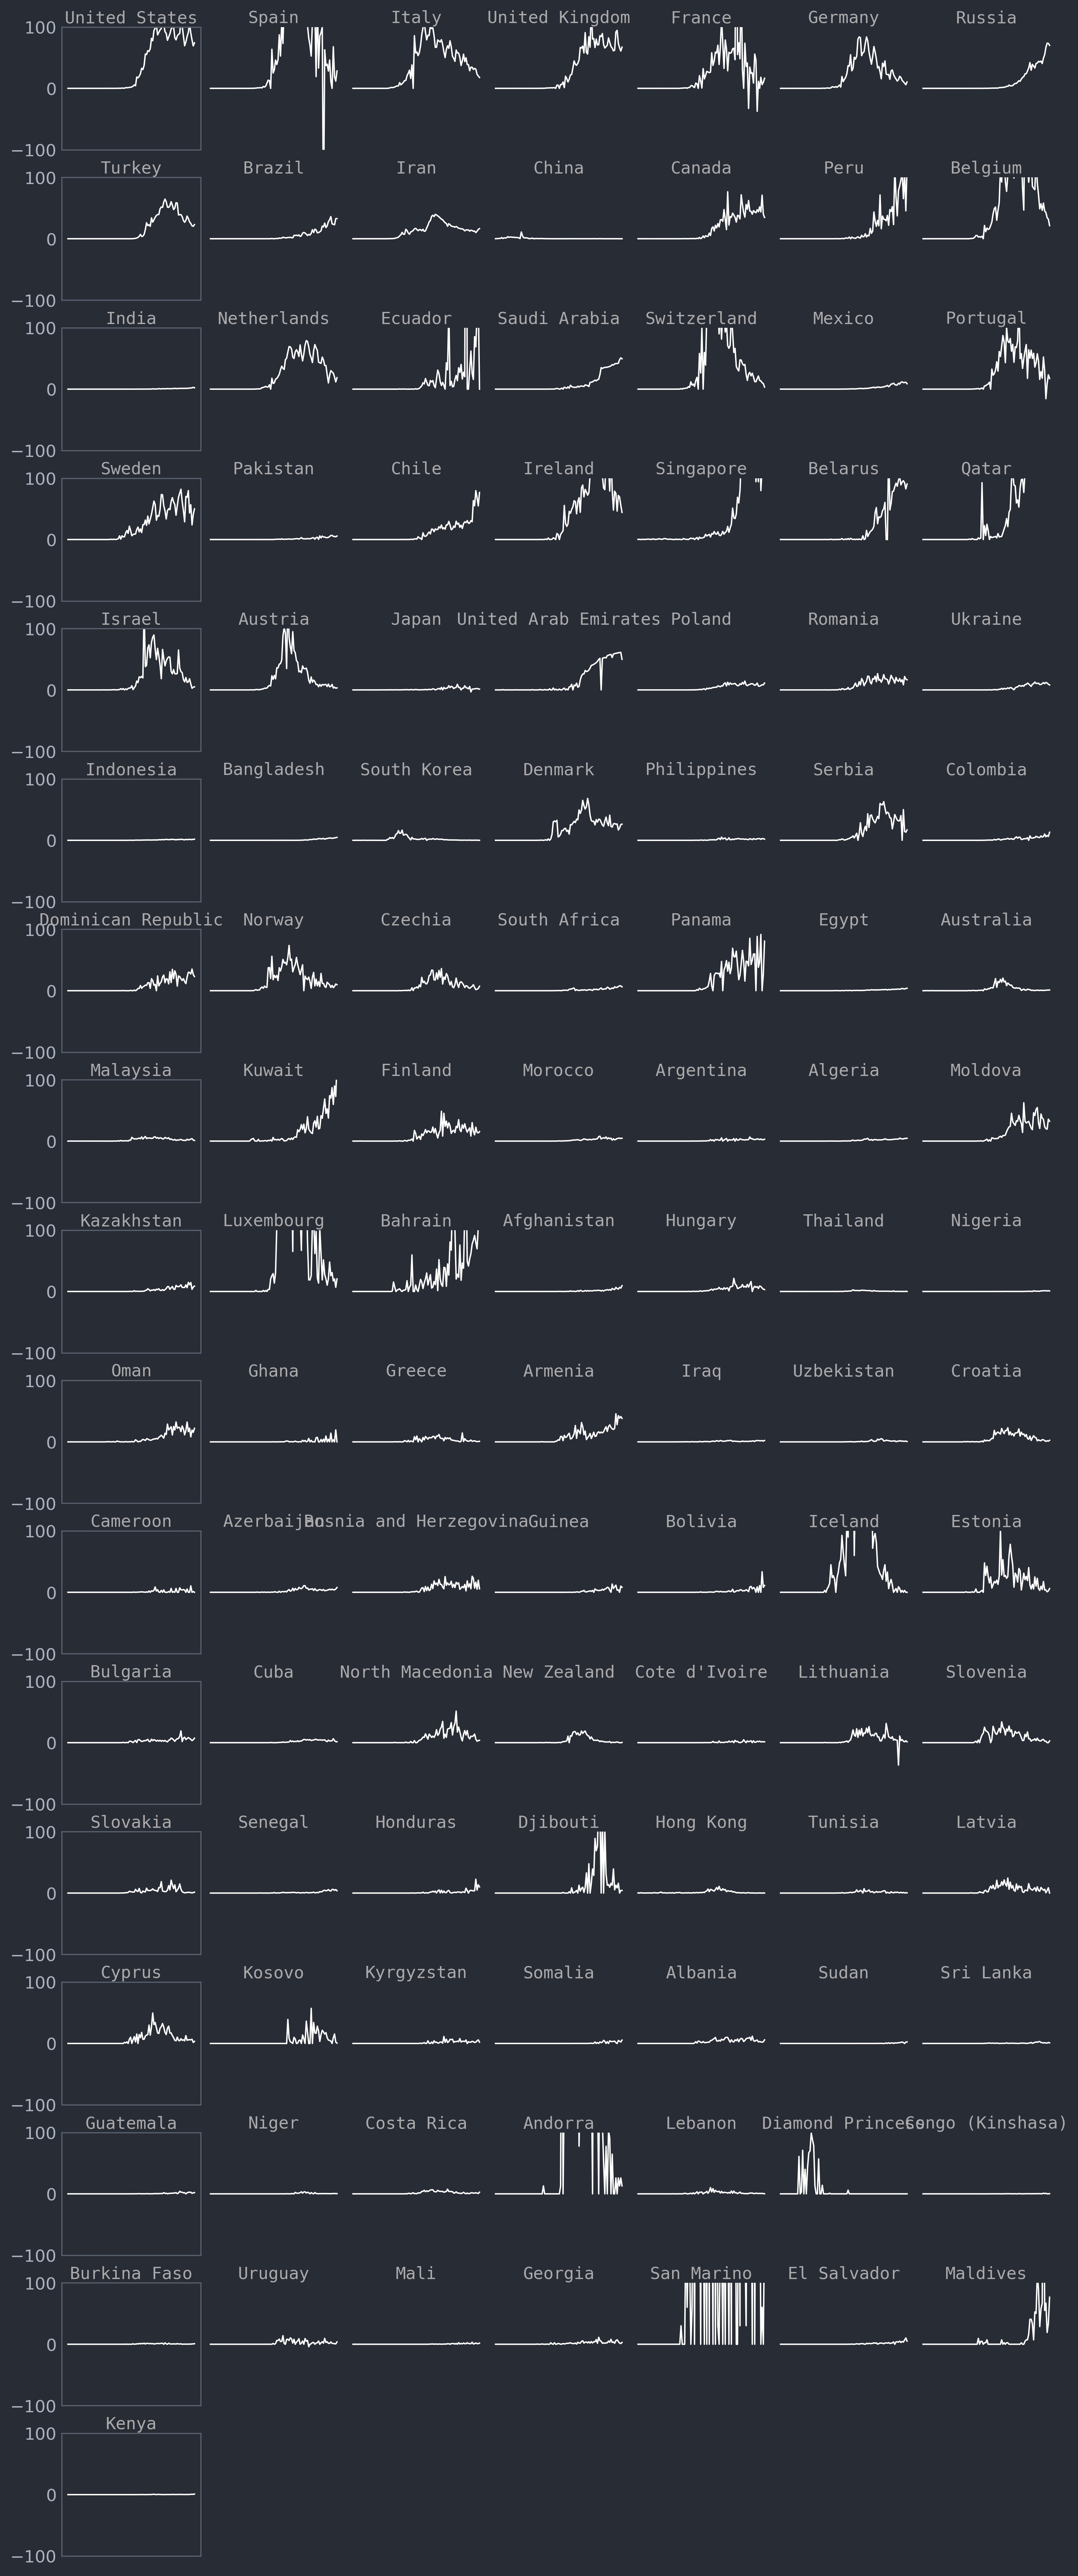

In [8]:
ncols = 7
nrows = math.ceil(len(countries)/ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols * 1.5, nrows * 1.5), dpi=300)
plt.tight_layout(h_pad=0, w_pad=-2)
plt.setp(ax, ylim=(-100, 100))

for i, str_country in enumerate(countries):
    df_cases_country = df_confirmed[df_confirmed['country']==str_country]
    df_cases_country['new_daily'] = df_cases_country.cases.diff()
    if df_countrypop[df_countrypop.Country == str_country]['Population'].empty:
        pop = 1000000
    else:
        pop = int(df_countrypop[df_countrypop.Country == str_country]['Population'])
    
    r = int(i / ncols)
    c = i % ncols
    axs = ax[r, c]
    
    axs.set_title(f"{str_country}", size=12, pad=3, color="#AAAAAA", fontproperties=prop)
    axs.plot(df_cases_country.index, df_cases_country.new_daily/pop*1000000
             ,lw=1, label=f"Confirmed cases", color="w")
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))

for r in range(nrows):
    for c in range(ncols):
        ax[r, c].xaxis.set_visible(False)
        if c % 7 != 0:
            ax[r, c].axis('off')
    
#bob = matplotlib.transforms.Bbox([[0.5, ncols-3.2], [4.7, ncols-0.16]])
plt.show();